In [100]:
from os.path import join
from os import getcwd
import json
from tqdm import tqdm

from dataset.Dataset import Dataset
from experiments.Analyser import accuracy_based_on_jacard_index
from graph.SpreadSheetGraph import SpreadSheetGraph
from labelregions.LabelRegionLoader import LabelRegionLoader
from search.ExhaustiveSearch import ExhaustiveSearch
from search.FitnessRater import FitnessRater, get_initial_weights


DATA_DIR = join(getcwd(), "../data")
OUTPUT_DIR = join(getcwd(), "output_final/output")

refined_file_path = join(DATA_DIR, "Deco", "refined.json")
with open(refined_file_path) as f:
    refined_data = json.load(f)

relevant_keys = [key for key, value in refined_data.items()] #  if value["edge_count"] > 10]

DECO = Dataset(join(DATA_DIR, "Deco"), "Deco")
FUSTE = Dataset(join(DATA_DIR, "FusTe"), "FusTe")

loader = LabelRegionLoader()

graphs = []
for sheet in tqdm(DECO.get_sheet_data(loader), total=DECO.sheet_data_count()):
    graphs.append(SpreadSheetGraph(sheet))


  6%|▌         | 37/622 [00:02<00:27, 21.08it/s]/home/tgarrels/.local/lib/python3.8/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
 36%|███▌      | 221/622 [00:11<00:36, 10.95it/s]/home/tgarrels/.local/lib/python3.8/site-packages/openpyxl/reader/drawings.py:29: UserWarning: DrawingML support is incomplete and limited to charts and images only. Shapes and drawings will be lost.
  warn("DrawingML support is incomplete and limited to charts and images only. Shapes and drawings will be lost.")
 50%|█████     | 313/622 [00:17<00:42,  7.21it/s]/home/tgarrels/.local/lib/python3.8/site-packages/openpyxl/reader/drawings.py:55: UserWarning: The image xl/media/image1.emf will be removed because it cannot be read
  warn(msg)
 91%|█████████ | 567/622 [00:28<00:02, 24.64it/s]/home/tgarrels/.local/lib/python3.8/site-packages/openpyxl/reader/drawings.py:59: UserWarn

In [118]:
from labelregions.LabelRegionType import LabelRegionType
from graph.Edge import ConnectionType

def header_lrs(graph):
    return list(filter(lambda x: x.type == LabelRegionType.HEADER, graph.nodes))

def data_lrs(graph):
    return list(filter(lambda x: x.type == LabelRegionType.DATA, graph.nodes))

def density(graph):
    return (2 * len(graph.edge_list)) / (len(graph.nodes) * (len(graph.nodes) - 1))


def edges_type_count(graph, connection_type: ConnectionType):
    return len([
        e
        for e in graph.edge_list
        if e.connection_type == connection_type
    ])

In [127]:
from graph.Edge import ConnectionType


def prediction_metric(graph):
    data = data_lrs(graph)
    header = header_lrs(graph)
    
    d_d = edges_type_count(graph, ConnectionType.D_D) + 1
    h_h = edges_type_count(graph, ConnectionType.H_H) + 1
    h_d = edges_type_count(graph, ConnectionType.D_H) + 1
    
    try:
        d_d_density = 2 * d_d / (len(data) * (len(data) - 1))
    except ZeroDivisionError:
        # No data or just one data region
        d_d_density = 0
    try:
        h_h_density = 2 * h_h / (len(header) * (len(header) - 1))
    except ZeroDivisionError:
        # No header or just one header region
        h_h_density = 0
    
    
    d_d_degree_avg = d_d / len(data_lrs(graph))
    h_h_degree_avg = h_h / len(header_lrs(graph))
    best = d_d_degree_avg * h_h_degree_avg
    
    return best
    

In [123]:
import matplotlib.pyplot as plt
from statistics import mean, median


def visualize_metric():

    single_agg = []
    multi_agg = []
    for g in graphs:
        if 10 < len(g.edge_list) <= 100:
            m = prediction_metric(g)
            if len(g.get_components()) == 1:
                single_agg.append(m)
            else:
                multi_agg.append(m)
    print(median(multi_agg))
    print(mean(multi_agg))
    plt.hist(single_agg, label="single")
    plt.hist(multi_agg, label="multi")
    plt.legend()
    plt.show()

    plt.boxplot([
            single_agg,
            multi_agg
        ],
        labels=["single", "multi"],
        vert=False,
        showmeans=True,
    )

0.9393382352941176
1.062141526293403


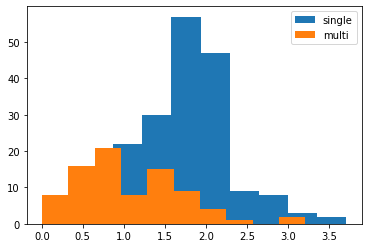

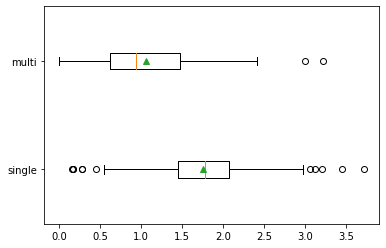

In [128]:
visualize_metric()

In [131]:
from random import sample
from statistics import median

from labelregions.LabelRegionType import LabelRegionType

def eval_metric(bound):
    
    predict_multi = lambda g: prediction_metric(g) <= bound

    single_as_multi = 0
    multi_as_multi = 0

    total_single = 0
    total_multi = 0

    for g in graphs:
        if 10 < len(g.edge_list) <= 100:
            components = g.get_components()
            if len(components) == 1:
                # Single
                total_single += 1
                multi = predict_multi(g)
                if multi:
                    single_as_multi += 1
            else:
                # Multi
                total_multi += 1
                multi = predict_multi(g)
                if multi:
                    multi_as_multi += 1

    precision = multi_as_multi / (multi_as_multi + single_as_multi)
    recall = multi_as_multi / total_multi

    # print(single_as_multi)
    print(f"Percent of singles predcited as multi: {single_as_multi / total_single:.4f}")
    # print(multi_as_multi)
    print(f"Percent of multi predcited as multi: {multi_as_multi / total_multi:.4f}")

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    f1 = 2 * precision * recall
    f1 /= precision + recall
    print(f"F1: {f1}")
        


In [136]:
eval_metric(0.8)

Percent of singles predcited as multi: 0.0524
Percent of multi predcited as multi: 0.4048
Precision: 0.7727272727272727
Recall: 0.40476190476190477
F1: 0.5312499999999999


In [113]:
import random

def eval_with_folds(fold_num):
    multi_graphs = [g for g in graphs if len(g.get_components()) > 1]
    single_graphs = [g for g in graphs if len(g.get_components()) == 1]
    print(len(multi_graphs))
    print(len(single_graphs))
    
    folds = []
    for _ in range(fold_num):
        test_single = random.sample(single_graphs, int(len(single_graphs) / fold_num))
        test_multi = random.sample(multi_graphs, int(len(multi_graphs) / fold_num))
        test = test_single + test_multi
        train = [g for g in graphs if g not in test]
        folds.append((test, train))
        
    f1_s = []
    for i, (test, train) in enumerate(folds):
        print(f"Fold {i}")
        # Train: Get median of multi-table
        multi = [g for g in train if len(g.get_components()) > 1]
        results = [prediction_metric(g) for g in multi]
        multi_median = median(results)
        
        # Test: Calc f1 against test set
        f1 = eval_metric(test, multi_median)
        f1_s.append(f1)

def eval_metric(test, bound):
    
    predict_multi = lambda g: prediction_metric(g) < bound

    single_as_multi = 0
    multi_as_multi = 0

    total_single = 0
    total_multi = 0

    for g in test:
        if 10 < len(g.edge_list) <= 100:
            components = g.get_components()
            if len(components) == 1:
                # Single
                total_single += 1
                multi = predict_multi(g)
                if multi:
                    single_as_multi += 1
            else:
                # Multi
                total_multi += 1
                multi = predict_multi(g)
                if multi:
                    multi_as_multi += 1
    


    # print(single_as_multi)
    print(f"Percent of singles predcited as multi: {single_as_multi / total_single:.4f}")
    if multi_as_multi == 0:
        return 0
    # print(multi_as_multi)
    print(f"Percent of multi predcited as multi: {multi_as_multi / total_multi:.4f}")
    

    precision = multi_as_multi / (multi_as_multi + single_as_multi)
    recall = multi_as_multi / total_multi
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    f1 = 2 * precision * recall
    f1 /= precision + recall
    print(f"F1: {f1}")
    return f1
        


In [116]:
eval_with_folds(10)

129
493
Fold 0
Percent of singles predcited as multi: 0.0588
Percent of multi predcited as multi: 0.7143
Precision: 0.8333333333333334
Recall: 0.7142857142857143
F1: 0.7692307692307692
Fold 1
Percent of singles predcited as multi: 0.0476
Percent of multi predcited as multi: 0.5000
Precision: 0.8
Recall: 0.5
F1: 0.6153846153846154
Fold 2
Percent of singles predcited as multi: 0.1000
Percent of multi predcited as multi: 0.3750
Precision: 0.6
Recall: 0.375
F1: 0.4615384615384615
Fold 3
Percent of singles predcited as multi: 0.0455
Percent of multi predcited as multi: 0.7143
Precision: 0.8333333333333334
Recall: 0.7142857142857143
F1: 0.7692307692307692
Fold 4
Percent of singles predcited as multi: 0.0952
Percent of multi predcited as multi: 0.6250
Precision: 0.7142857142857143
Recall: 0.625
F1: 0.6666666666666666
Fold 5
Percent of singles predcited as multi: 0.0588
Fold 6
Percent of singles predcited as multi: 0.1250
Percent of multi predcited as multi: 0.2500
Precision: 0.4
Recall: 0.25
